In [1]:
import torch
import torchvision
from torch import nn
from transformers import AutoTokenizer, CLIPModel, CLIPVisionModelWithProjection
from train_c_controlnet import WurstCore
from train_b import WurstCore as WurstCoreB
from warp_core.utils import load_or_fail
import yaml
import matplotlib.pyplot as plt
from PIL import Image
import requests

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [2]:
# SETUP WARPCORE
# config_file = 'configs/controlnet_c_3b_base.yml'
# config_file = 'configs/controlnet_c_3b_canny.yml'
# config_file = 'configs/controlnet_c_3b_inpainting.yml'
# config_file = 'configs/controlnet_c_3b_qr.yml'
# config_file = 'configs/controlnet_c_3b_sr.yml'
config_file = 'configs/controlnet_c_3b_identity.yml'
# config_file = 'configs/controlnet_c_3b_identity_v2.yml'
with open(config_file, "r", encoding="utf-8") as file:
    loaded_config = yaml.safe_load(file)
    loaded_config['use_fsdp'] = False
    loaded_config['batch_size'] = 4
    
    # Humans 7M
    loaded_config['captions_getter']  = ['combined_txt', 'identity']
    loaded_config['webdataset_path'] = 'pipe:aws s3 cp s3://laion-west/humans-7M-with-blip-caps+aesthetics+nsfw/00000{1..5499}.tar -'

warpcore = WurstCore(
    config_dict=loaded_config,
    device=device
)

# STAGE B
config_file_b = 'configs/finetune_b_3b.yml'
with open(config_file_b, "r", encoding="utf-8") as file:
    config_file_b = yaml.safe_load(file)
    config_file_b['use_fsdp'] = False
    config_file_b['batch_size'] = 4
    
warpcore_b = WurstCoreB(
    config_dict=config_file_b,
    device=device
)

>>> RESUMING TRAINING FROM ITER  82000


In [3]:
# SETUP MODELS & DATA
extras = warpcore.setup_extras_pre()
data = warpcore.setup_data(extras)
models = warpcore.setup_models(extras)
models.generator.bfloat16().eval().requires_grad_(False)
print("CONTROLNET READY")

extras_b = warpcore_b.setup_extras_pre()
models_b = warpcore_b.setup_models(extras_b)
models_b.generator.bfloat16().eval().requires_grad_(False)
print("STAGE B READY")
pass

Training with batch size 4 (4/GPU)


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPVisionModelWithProjection: ['text_model.encoder.layers.1.self_attn.q_proj.weight', 'text_model.encoder.layers.5.self_attn.out_proj.weight', 'text_model.encoder.layers.8.layer_norm2.bias', 'text_model.encoder.layers.9.layer_norm2.weight', 'text_model.encoder.layers.9.self_attn.k_proj.bias', 'text_model.encoder.layers.3.self_attn.k_proj.bias', 'text_model.encoder.layers.1.self_attn.v_proj.bias', 'text_model.encoder.layers.11.self_attn.out_proj.bias', 'text_model.encoder.layers.11.self_attn.q_proj.weight', 'text_model.encoder.layers.4.mlp.fc2.bias', 'text_model.encoder.layers.6.mlp.fc1.bias', 'text_model.encoder.layers.1.self_attn.k_proj.bias', 'text_model.encoder.layers.10.mlp.fc1.bias', 'text_model.encoder.layers.3.layer_norm1.weight', 'text_model.encoder.layers.6.layer_norm2.weight', 'text_model.encoder.layers.2.self_attn.out_proj.weight', 'text_model.encoder.layers.4.self_attn.v_p

CONTROLNET READY


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

STAGE B READY


In [4]:
print("TOTAL PARAMS:", sum(p.numel() for p in models.controlnet.parameters() if p.requires_grad))
print("BACKBONE PARAMS:", sum(p.numel() for p in models.controlnet.backbone.parameters() if p.requires_grad))

TOTAL PARAMS: 102763008
BACKBONE PARAMS: 18876928


In [5]:
# LOAD CHECKPOINT
# models.controlnet.load_state_dict(load_or_fail("/weka/home-warp/models/v3_release/stage_c_3b_controlnet_canny/controlnet_2k.safetensors"))
# models.controlnet.load_state_dict(load_or_fail("/weka/home-warp/models/v3_release/stage_c_3b_controlnet_canny/controlnet_10k.safetensors"))
# models.controlnet.load_state_dict(load_or_fail("/weka/home-warp/models/v3_release/stage_c_3b_controlnet_inpainting/controlnet_10k.safetensors"))
# models.controlnet.load_state_dict(load_or_fail("/weka/home-warp/models/v3_release/stage_c_3b_controlnet_sr/controlnet_10k.safetensors"))
models.controlnet.load_state_dict(load_or_fail("/weka/home-warp/models/v3_release/stage_c_3b_controlnet_identity/controlnet.safetensors"))


<All keys matched successfully>

torch.Size([4, 3, 768, 768])


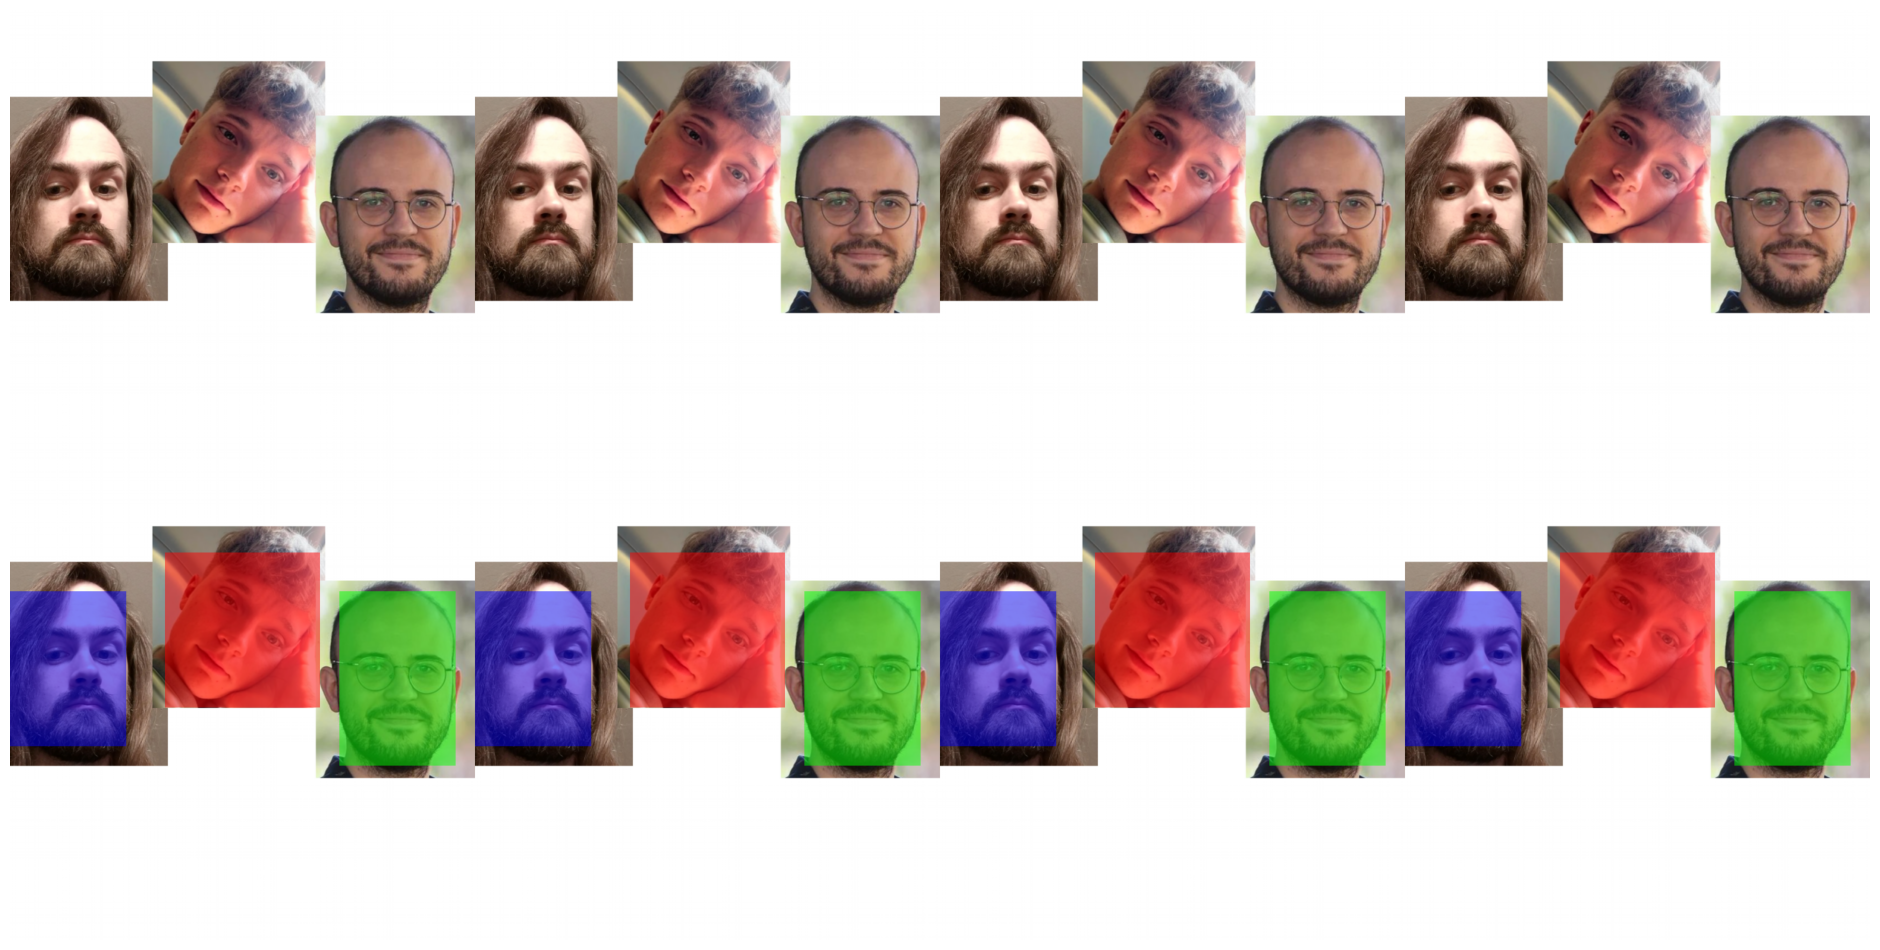

In [685]:
# PREVIEW BATCH
batch = next(data.iterator)

# Override Controlnet
cnet_override = None
# url = "https://t3.ftcdn.net/jpg/02/96/04/04/360_F_296040417_6ANFXe238jcp5sGNPXfeF8sJ21VXJL9F.jpg" # CAT
# url = "https://i.pinimg.com/474x/47/c1/a1/47c1a130bd0981d4543ce3083c855f84.jpg" # FACE
# url = "https://img.freepik.com/vector-gratis/fondo-espiral-blanco-negro_1048-16005.jpg?size=626&ext=jpg&ga=GA1.1.1880011253.1699574400&semt=ais" # SPIRAL
# url = "https://cdn.discordapp.com/attachments/1039261364935462942/1197703805400260718/Captura_de_pantalla_2024-01-19_a_las_1.47.13.png?ex=65bc3b97&is=65a9c697&hm=ea02e4dbceb5d74a594ff40ea6d1d3da0a4d7a60de311c68210df8411f46b20c&" # SWAN
# url = "https://media.es.wired.com/photos/655dabe4eb48c3d383bdfe1f/master/pass/Sam-Altman-OpenAI-Return-Business-1258197415.jpg" # SAM ALTMAN
# url = "https://cdn.discordapp.com/attachments/1039261364935462942/1197882045435752538/Captura_de_pantalla_2024-01-19_a_las_13.35.31.png?ex=65bce197&is=65aa6c97&hm=2d754950b98615b6e18d37b0e51fef076f4958f01e3984846a877a188b3afe80&" # ICLR
# url = "https://i2.wp.com/zet.gallery/blog/wp-content/uploads/2016/02/Vicent-Van-Gogh-Starry-Night-Famous-Oil-Paintings-www.shairart.com_.jpg?fit=1280%2C1014"
# url = "https://cdn.discordapp.com/attachments/1039261364935462942/1198059556048207882/asdf.jpg?ex=65bd86e9&is=65ab11e9&hm=886f0a0262b91b5ae15560566a7c50c33cbce9909ad2a3aa8174dfd0ab9e6345&" # NAPOLEON
# url = "https://cdn.discordapp.com/attachments/1198177251238363219/1198309860756963468/brad-pitt-attends-the-premiere-of-20th-century-foxs--square.jpg?ex=65be7006&is=65abfb06&hm=2c9632a1d37ad9e776dad0db96966ade519e25ad6c7dde00793b01af0f0836f6&" # BRAD PITT
# url = "https://www.plusesmas.com/pictures/biografias/5000/5759.jpg" # Obama
# url = "https://static.wikia.nocookie.net/doblaje/images/7/71/Jackblack.jpg/revision/latest?cb=20230406051828&path-prefix=es" # Jack Black
# url = "https://assets-global.website-files.com/64ee00624cf457e21d6c34d7/6527bcaaa2f68d2a47c4f7ad_pablo.jpg" # PABLO
# url = "https://estaticos-cdn.prensaiberica.es/clip/084747ad-32fb-4165-bad6-fe68cfbf4b0b_21-9-aspect-ratio_default_0_x1413y576.jpg" # PABLO 2
# url = "https://assets-global.website-files.com/64ee00624cf457e21d6c34d7/65967f445c4dca1a769074c0_dome-opt-1920.jpeg" # DOME
# url = "https://s3.abcstatics.com/abc/www/multimedia/gente/2023/09/30/miley-cyrus-U12836307500YgX-1200x630@abc.jpg" # MILEY
# url = "https://diarium.usal.es/zhangna/files/2012/11/55851233968748656.jpg" # JACKIE CHAN
# url = "https://cdn.discordapp.com/attachments/1039261364935462942/1199885986184822884/Captura_de_pantalla_2024-01-25_a_las_2.18.24.png?ex=65c42be7&is=65b1b6e7&hm=b3945a088de22230efe506e9e6a894b4b1d0d3295c727ac924cf3fb1832827af&" # JACKI AND CHRIS
# url = "https://cdn.discordapp.com/attachments/1039261364935462942/1199886812844404767/Captura_de_pantalla_2024-01-25_a_las_2.21.42.png?ex=65c42cad&is=65b1b7ad&hm=cb1c3501b4535d23c3f183e8a14d253451fee1e8bc3eb430d4633c965ae6caa0&" # IRISHMAN
# url = "https://www.drjamesdobson.org/hubfs/02132017WHATWOMENSHOULDKNOWABOUTMEN_image.jpg" # couple
# url = "https://www.mcgawgraphics.com/cdn/shop/products/V495_bfc78f33-3b1a-40ec-bd64-f85c4ec05fa4_1200x.jpg?v=1599063465" # Van Gogh
# url = "https://media.posterlounge.com/img/products/130000/129650/129650_poster.jpg" # MONA LISA
# url = "https://cv1.cpd.ua.es/WebCv/FotosCarnetPer/56/42421566_20220601133856.jpg" # PEDRO
# url = "https://cdn.discordapp.com/attachments/1183091956033798164/1200100080179478618/lol.jpg?ex=65c4f34b&is=65b27e4b&hm=7ae281a5f2a022777e3b313b1eec8e953f55707b93f6d536d19ce47aa576018a&" # Harris
# url = "https://cdn.discordapp.com/attachments/1183091956033798164/1200112422334247052/DSC_7348.JPG?ex=65c4feca&is=65b289ca&hm=980a4d478ecd3574a9ad7bce9605d465fe142175887d100fa303eccc59660288&"# Harris 2
url = "https://cdn.discordapp.com/attachments/1039261364935462942/1200109692978999317/three_people.png?ex=65c4fc3f&is=65b2873f&hm=064a8cebea5560b74e7088be9d1399a5fe48863d1581e65ea9d6734725f4c8d3&" # Model Wranglers
# url = "https://cdn.discordapp.com/attachments/1039261364935462942/1200113087144013834/three_people.png?ex=65c4ff68&is=65b28a68&hm=ae978ddd81d0784166e1ac23cd0eacf2dea40dac8e3aa66bcab040681c0e1cae&" # Model Wranglers 2
# url = "https://cdn.discordapp.com/attachments/1039261364935462942/1200115408456388761/three_people.png?ex=65c50192&is=65b28c92&hm=19b4353cfd7fdd227d553246b334c130e9935eea0fd7763aa301cf63cd3e62de&" # Model Wranglers 3
# url = "https://prevencontrol.com/wp-content/uploads/2021/11/Apple_TV_Ted_Lasso_Key_Art_S2.png" # TED LASSO
# url = "https://www.metroworldnews.com/resizer/Ulhb2wSM3iDPDQ8Go4ULjL3tix8=/800x0/filters:format(jpg):quality(70)/cloudfront-us-east-1.images.arcpublishing.com/metroworldnews/LRU3PGCP5NCURAZFCRXSS7HY5I.jpg" # THE ROCK
# url = "https://people.com/thmb/PY7JzC8k-7tizI_L4cv_51AYt6Q=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc():focal(749x0:751x2)/mark-ruffalo-2-be49cbd7d3874829a64c4dbb2c41042f.jpg" # MARK RUFFALO
# url = "https://m.media-amazon.com/images/M/MV5BMTM0NDIxMzQ5OF5BMl5BanBnXkFtZTcwNzAyNTA4Nw@@._V1_.jpg" # Elija Wood
images = extras.transforms(Image.open(requests.get(url, stream=True).raw).convert("RGB")).unsqueeze(0).to(device)
images = images.expand(batch['images'].size(0), -1, -1, -1)
# with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
#     cnet_override = models.controlnet(1-images.mean(dim=1, keepdim=True))

# multi_urls = [
# #     "https://www.plusesmas.com/pictures/biografias/5000/5759.jpg",
# #     "https://static.eldiario.es/clip/42872bc0-169c-4d3d-a235-2f52b625a5c7_16-9-aspect-ratio_default_0.jpg",
# #     "https://static.eldiario.es/clip/52bb2d7e-c456-41a1-b650-aa4d6d320c2c_16-9-discover-aspect-ratio_default_0_x492y308.jpg",
# #     "https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Donald_Trump_official_portrait.jpg/1200px-Donald_Trump_official_portrait.jpg",
# #     "https://cdn.discordapp.com/attachments/1198177251238363219/1198309860756963468/brad-pitt-attends-the-premiere-of-20th-century-foxs--square.jpg?ex=65be7006&is=65abfb06&hm=2c9632a1d37ad9e776dad0db96966ade519e25ad6c7dde00793b01af0f0836f6&",
# #     "https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/Brad_Pitt_2019_by_Glenn_Francis.jpg/1200px-Brad_Pitt_2019_by_Glenn_Francis.jpg",
# #     "https://imagenes.20minutos.es/files/image_640_360/uploads/imagenes/2023/12/15/brad-pitt-en-el-grand-prix-de-las-vegas-noviembre-de-2023.jpeg",
# #     "https://imagenes.elpais.com/resizer/Fa0ef_BO3RMLI2FzXXvgBhZsNkQ=/1200x0/cloudfront-eu-central-1.images.arcpublishing.com/prisa/3N64JSCVGJARHO6U5MUQ7YR37Y.jpg",
#     "https://assets-global.website-files.com/64ee00624cf457e21d6c34d7/6527bcaaa2f68d2a47c4f7ad_pablo.jpg",
#     "https://estaticos-cdn.prensaiberica.es/clip/084747ad-32fb-4165-bad6-fe68cfbf4b0b_21-9-aspect-ratio_default_0_x1413y576.jpg",
#     "https://media.licdn.com/dms/image/D5603AQFthByuWMsvoA/profile-displayphoto-shrink_800_800/0/1685892118507?e=2147483647&v=beta&t=-do5QOcSkR81vgITREI1PRlbhtrk8utxNek9vGN5cBA",
#     "https://i.pinimg.com/280x280_RS/1c/62/1d/1c621d95726b9b68c87c045bfacf96f8.jpg",
# ]
# images = torch.stack([extras.transforms(Image.open(requests.get(url, stream=True).raw).convert("RGB")) for url in multi_urls], dim=0).to(device)

batch['images'] = images.cpu()
# batch['images'] = nn.functional.interpolate(batch['images'], scale_factor=2, mode='nearest')

with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
    cnet, cnet_input = warpcore.get_cnet(batch, models, extras)
    cnet_uncond = warpcore.get_cnet({'images': torch.zeros_like(batch['images'])}, models, extras)[0]
    
if cnet_override is None:
    with torch.no_grad():
        if cnet_input.size(1) == 1:
            cnet_input = cnet_input.repeat(1, 3, 1, 1)
        elif cnet_input.size(1) > 3:
            cnet_input_extra_channels = cnet_input[:, 3:]     
            cnet_input = cnet_input[:, :3]     
        print(cnet_input.shape)
else:
    cnet = cnet_override
    cnet_input = 1-images.mean(dim=1, keepdim=True).cpu().expand(-1, 3, -1, -1)

plt.figure(figsize=(24, 24))
plt.axis("off")
plt.imshow(torch.cat([
    torch.cat([i for i in batch['images'].clamp(0, 1)], dim=-1),
    torch.cat([i for i in cnet_input.clamp(0, 1).cpu()], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

In [686]:
# plt.figure(figsize=(24, 24))
# plt.axis("off")
# plt.imshow(torch.cat([
#     torch.cat([i for i in cnet_input_extra_channels.expand(-1, 3, -1, -1).clamp(0, 1)], dim=-1),
# ], dim=-2).permute(1, 2, 0).cpu())
# plt.show()

In [747]:
# batch['captions'] = ['colorful crayon drawing by a toddler, pastel colors'] * len(batch['captions'])
# batch['captions'] = ['Pixar style animation, still frame from Pixar movie Toy Story'] * len(batch['captions'])
# batch['captions'] = ['interesting image made with play-doh'] * len(batch['captions'])
# batch['captions'] = ['Oil painting portrait'] * len(batch['captions'])
# batch['captions'] = ['Beautiful watercolor'] * len(batch['captions'])
# batch['captions'] = ['oil painting of a swan by Botticelli'] * len(batch['captions'])
# batch['captions'] = ['oil painting of a dragon by Botticelli'] * len(batch['captions'])
# batch['captions'] = ['closeup photo of an android'] * len(batch['captions'])
# batch['captions'] = ['closeup photo of a greek marble sculpture wearing makeup'] * len(batch['captions'])
# batch['captions'] = ['closeup drawing of a Disney princess'] * len(batch['captions'])
# batch['captions'] = ['Play-doh figurine of a cute white cat surounded by other play-doh figures'] * len(batch['captions'])
# batch['captions'] = ['Photo of a man with facial hair'] * len(batch['captions'])
# batch['captions'] = ['still shot from Spirited Away. A warrior looking with desdain during a battle, anime flat colors'] * len(batch['captions'])
# batch['captions'] = ['watercolor painting of a man'] * len(batch['captions'])
# batch['captions'] = ['closeup photography of a man in the city, cinematic'] * len(batch['captions'])
# batch['captions'] = ['Anime style, closeup illustration of the face of a man'] * len(batch['captions'])
# batch['captions'] = ['colorful crayon drawing of a man by a toddler, pastel color'] * len(batch['captions'])
# batch['captions'] = ['greek statue of a man in a museum, a woman is posing for a selfie next to it'] * len(batch['captions'])
batch['captions'] = ['In the style of Don Bluth, Jozef Szekeres. MCU closeup of group of men, the one in the right is bald, scenery from She-ra, flat animation, 8k'] * len(batch['captions'])
# batch['captions'] = ['Disney Pixar character, a group of men that live in LA, movie poster with the text "DIFFUSION WRANGLERS"'] * len(batch['captions'])
# batch['captions'] = ['Roman white marble sculpture depicting three philosophers thinking'] * len(batch['captions'])


In [748]:
# PREPARE CONDITIONS
conditions = warpcore.get_conditions(batch, models, extras, is_eval=True, is_unconditional=False, eval_image_embeds=False)
unconditions = warpcore.get_conditions(batch, models, extras, is_eval=True, is_unconditional=True, eval_image_embeds=False)    


In [749]:
# batch['captions'] = ['closeup of a woman'] * len(batch['captions'])
# conditions = warpcore.get_conditions(batch, models, extras, is_eval=True, is_unconditional=False, eval_image_embeds=False)

# batch['captions'] = ["young, smooth skin, happy, beautiful"] * len(batch['captions'])
# unconditions = warpcore.get_conditions(batch, models, extras, is_eval=True, is_unconditional=False, eval_image_embeds=False)
                                                                  

In [750]:
print(batch['images'].shape)
cnet_alt = warpcore.get_cnet({'images': torch.zeros_like(batch['images'])}, models, extras)[0]
print(cnet_alt[0].shape)

torch.Size([4, 3, 768, 768])
torch.Size([4, 2048, 24, 24])


In [751]:
# cnet[0].shape

cnet_input = extras.controlnet_filter(images)

In [752]:
cnet_multiplier = 1.0 # 0.8 # 0.3
conditions['cnet'] = [c.clone() * cnet_multiplier if c is not None else c for c in cnet]
# conditions['cnet'] = [c.clone().mean(dim=0, keepdim=True).expand(c.size(0), -1, -1, -1) * cnet_multiplier if c is not None else c for c in cnet] # BATCH IDENTITY MERGE
# unconditions['cnet'] = [c.clone() * cnet_multiplier if c is not None else c for c in cnet]
unconditions['cnet'] = [c.clone() * cnet_multiplier if c is not None else c for c in cnet_uncond]
print("CNet Layers:", [i for i, p in enumerate(conditions['cnet']) if p is not None])


CNet Layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]


In [753]:
# SAMPLE
extras.sampling_configs['cfg'] = 4
extras.sampling_configs['shift'] = 2
extras.sampling_configs['timesteps'] = 20
# extras.sampling_configs['t_start'] = 1.0
print(extras.sampling_configs)

with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16), torch.random.fork_rng():
    torch.manual_seed(42)
    
    *_, (sampled_latents, _, _) = extras.gdf.sample(
        models.generator, conditions, (4, 16, 24, 24), # (4, 16, 24, 24),
        unconditions, device=device, **extras.sampling_configs
    )
    sampled = models.previewer(sampled_latents).float()
    print(sampled_latents.shape, sampled.shape)
    
    effnet_latents = warpcore.encode_latents(batch, models, extras)
    decoded = models.previewer(effnet_latents).float()

{'cfg': 4, 'sampler': <gdf.samplers.DDPMSampler object at 0x7f7aa2e5d1c0>, 'shift': 2, 'timesteps': 20}
torch.Size([4, 16, 24, 24]) torch.Size([4, 3, 192, 192])


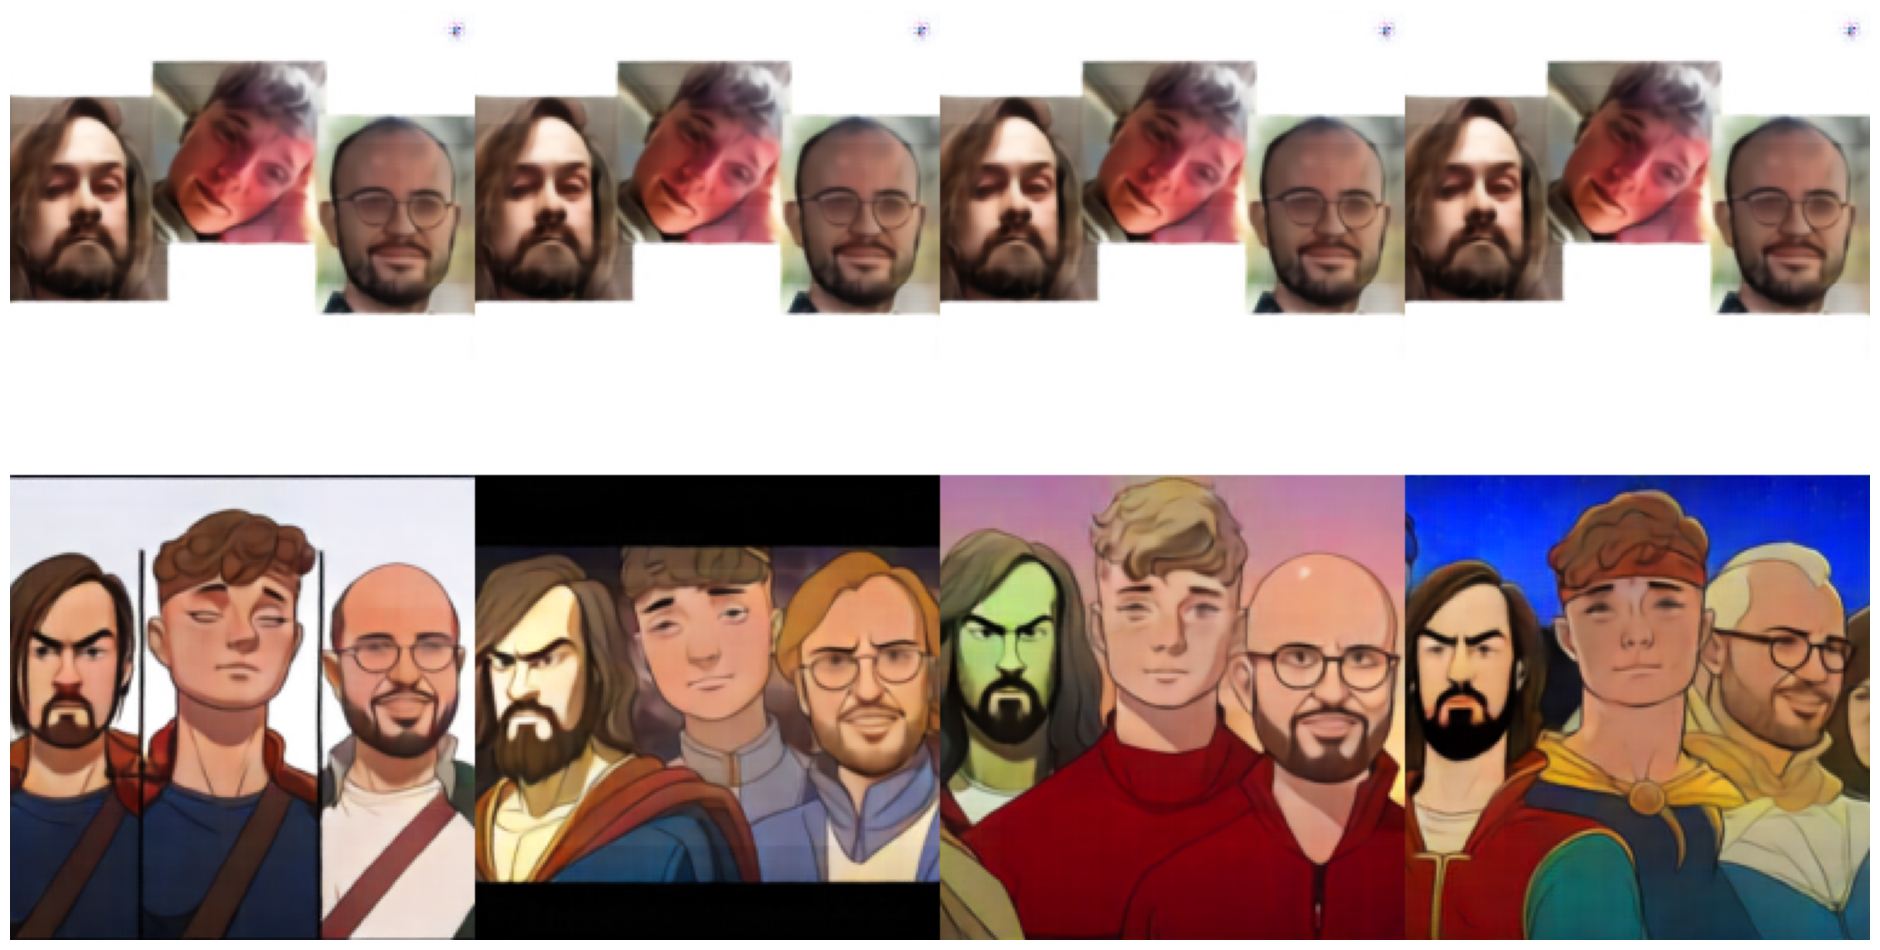

In [754]:
# VISUALIZE SAMPLES
# merged = decoded.clone()
# merged[:, :, :, 96:] = sampled[:, :, :, 96:]

plt.figure(figsize=(24, 24))
plt.axis("off")
plt.imshow(torch.cat([
    torch.cat([i for i in decoded.cpu().clamp(0, 1)], dim=-1),
    torch.cat([i for i in sampled.cpu().clamp(0, 1)], dim=-1),
#     torch.cat([i for i in merged.cpu().clamp(0, 1)], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

In [755]:
# STAGE B SAMPLING
conditions_b = warpcore_b.get_conditions(batch, models_b, extras_b, is_eval=True, is_unconditional=False, eval_image_embeds=False)
unconditions_b = warpcore_b.get_conditions(batch, models_b, extras_b, is_eval=True, is_unconditional=True, eval_image_embeds=False)
conditions_b['effnet'] = sampled_latents
unconditions_b['effnet'] = torch.zeros_like(sampled_latents)


In [756]:
# SAMPLE
# extras_b.sampling_configs['cfg'] = 1.5
# extras_b.sampling_configs['shift'] = 1
# extras_b.sampling_configs['timesteps'] = 10
# extras_b.sampling_configs['t_start'] = 1.0
print(extras_b.sampling_configs)

with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16), torch.random.fork_rng():
    torch.manual_seed(42)
    
    *_, (sampled_latents_b, _, _) = extras_b.gdf.sample(
        models_b.generator, conditions_b, (4, 4, 256, 256), # (4, 4, 256, 256),
        unconditions_b, device=device, **extras_b.sampling_configs
    )
    sampled_b = models_b.stage_a.decode(sampled_latents_b).float()
    print(sampled_latents.shape, sampled_b.shape)

{'cfg': 1.5, 'sampler': <gdf.samplers.DDPMSampler object at 0x7f7a981ca3a0>, 'shift': 1, 'timesteps': 10}
torch.Size([4, 16, 24, 24]) torch.Size([4, 3, 1024, 1024])


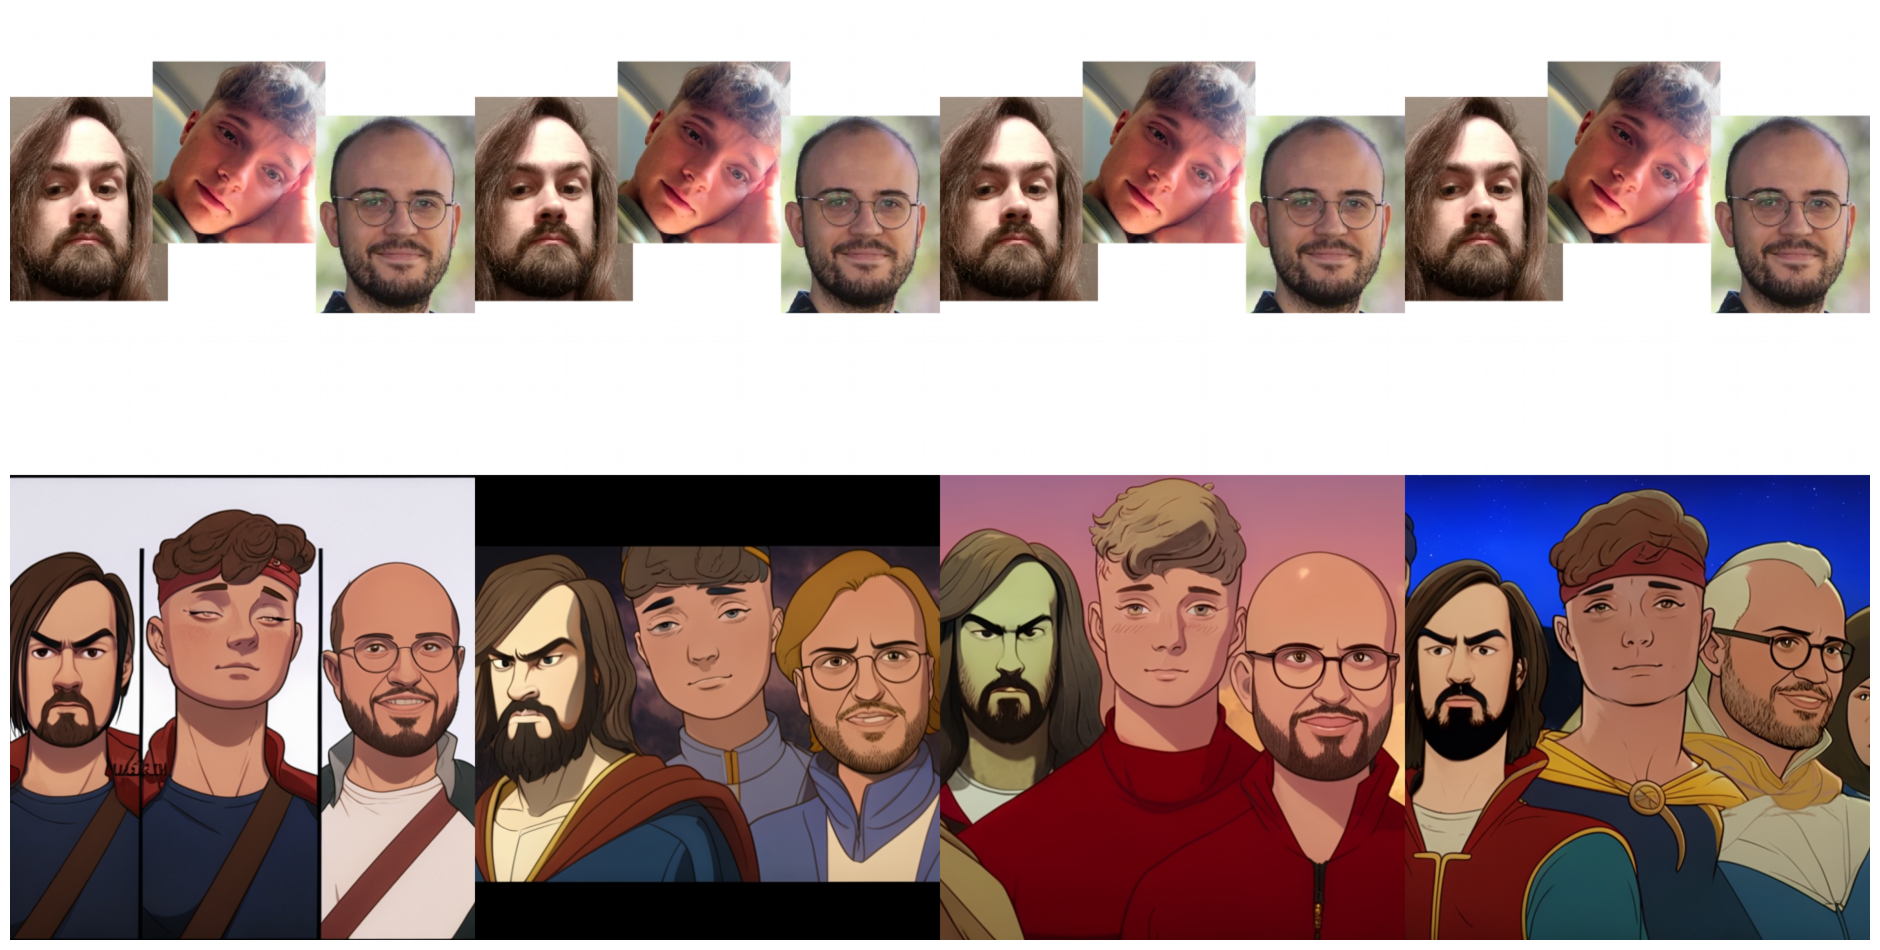

In [757]:
plt.figure(figsize=(24, 24))
plt.axis("off")
plt.imshow(torch.cat([
    torch.cat([i for i in nn.functional.interpolate(batch['images'], size=sampled_b.shape[-2:]).cpu().clamp(0, 1)], dim=-1),
    torch.cat([i for i in sampled_b.cpu().clamp(0, 1)], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()
# 
torchvision.utils.save_image(torch.cat([
    torch.cat([i for i in nn.functional.interpolate(batch['images'], size=sampled_b.shape[-2:]).cpu().clamp(0, 1)], dim=-1),
    torch.cat([i for i in sampled_b.cpu().clamp(0, 1)], dim=-1),
], dim=-2), f'controlnet_sample.jpg')